# Dropout prediction and rule mining for Sozialwissenschaften

## Dropout when no exams in last three semesters

In [1]:
import pandas as pd
import numpy as np

from rapp import data

In [2]:
data.connect("data/rapp.db")

In [3]:
sql = "sql/sw_base_modules_dropout.sql"
df = data.query_sql_file(sql, data.db_conn)

df


,Geburtsjahr,Geschlecht,Deutsch,AlterEinschreibung,EV_AP_Bestanden,EV_AP_Note,EV_AP_Versuche,EV2_AP_Bestanden,EV2_AP_Note,EV2_AP_Versuche,Sozi_AP_Bestanden,Sozi_AP_Note,Sozi_AP_Versuche,Polit_AP_Bestanden,Polit_AP_Note,Polit_AP_Versuche,Komm_AP_Bestanden,Komm_AP_Note,Komm_AP_Versuche,Dropout
0,1989,weiblich,0,21,1,1.7,1,1,2.0,1,1,3.3,1,1,2.0,1,1,3.7,1,0
1,1991,männlich,1,19,1,1.7,2,1,1.7,1,1,3.0,1,1,2.3,1,1,3.0,1,0
2,1990,weiblich,1,20,1,1.7,1,0,5.0,0,1,2.3,1,1,2.3,1,1,3.7,1,0
3,1989,männlich,1,21,1,1.7,2,1,2.0,1,0,5.0,0,1,1.0,1,1,2.7,1,0
4,1990,männlich,1,20,1,2.7,1,1,3.0,1,1,2.3,1,1,3.7,1,0,5.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
863,1998,männlich,1,20,1,2.7,1,1,4.0,1,1,4.0,1,0,5.0,1,0,5.0,1,1
864,1997,weiblich,1,21,1,2.7,1,0,5.0,0,0,5.0,0,0,5.0,0,0,5.0,1,1
865,1998,weiblich,1,20,1,3.3,2,0,5.0,0,0,5.0,0,0,5.0,1,0,5.0,1,1
866,1998,weiblich,1,20,1,3.7,1,0,5.0,0,0,5.0,0,0,5.0,0,0,5.0,0,1


In [4]:
def print_metric(cols, df):
    rows = len(df)
    for col in cols:
        count = len(df[df[col]==1])
        print(f"{col}:", count, f"({count*100./rows} %)")

In [5]:
print_metric(["Dropout", "EV_AP_Bestanden", "Polit_AP_Bestanden", "Sozi_AP_Bestanden", "Komm_AP_Bestanden"], df)

Dropout: 307 (35.36866359447004 %)
EV_AP_Bestanden: 762 (87.78801843317973 %)
Polit_AP_Bestanden: 600 (69.12442396313364 %)
Sozi_AP_Bestanden: 356 (41.013824884792626 %)
Komm_AP_Bestanden: 584 (67.28110599078342 %)


In [6]:
# Preprocess data
df_classification = df.copy(deep=True)
df_classification["Männlich"] = 1*(df_classification["Geschlecht"] == "männlich")
df_classification["Weiblich"] = 1*(df_classification["Geschlecht"] == "weiblich")
df_classification["Divers"] = 1*(df_classification["Geschlecht"] == "divers")

df_classification = df_classification.drop(["Geschlecht", "Geburtsjahr"], axis=1)
df_classification.head()

,Deutsch,AlterEinschreibung,EV_AP_Bestanden,EV_AP_Note,EV_AP_Versuche,EV2_AP_Bestanden,EV2_AP_Note,EV2_AP_Versuche,Sozi_AP_Bestanden,Sozi_AP_Note,...,Polit_AP_Bestanden,Polit_AP_Note,Polit_AP_Versuche,Komm_AP_Bestanden,Komm_AP_Note,Komm_AP_Versuche,Dropout,Männlich,Weiblich,Divers
0,0,21,1,1.7,1,1,2.0,1,1,3.3,...,1,2.0,1,1,3.7,1,0,0,1,0
1,1,19,1,1.7,2,1,1.7,1,1,3.0,...,1,2.3,1,1,3.0,1,0,1,0,0
2,1,20,1,1.7,1,0,5.0,0,1,2.3,...,1,2.3,1,1,3.7,1,0,0,1,0
3,1,21,1,1.7,2,1,2.0,1,0,5.0,...,1,1.0,1,1,2.7,1,0,1,0,0
4,1,20,1,2.7,1,1,3.0,1,1,2.3,...,1,3.7,1,0,5.0,0,1,1,0,0


In [7]:
print_metric(["Männlich", "Weiblich", "Divers"], df_classification)

Männlich: 300 (34.56221198156682 %)
Weiblich: 568 (65.43778801843318 %)
Divers: 0 (0.0 %)


### Training the model

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [9]:
def eval_model(clf):
    y_pred = clf.predict(X_train)
    bacc = balanced_accuracy_score(y_train, y_pred)
    area = roc_auc_score(y_train, y_pred)
    conf = confusion_matrix(y_train, y_pred)
    print("# Trainset")
    print(f"Balanced accuracy: {bacc}")
    print(f"Area under curve: {area}")
    print(f"Confusion Matrix (tn, fp, fn, tp):")
    print(conf)

    y_pred = clf.predict(X_test)
    bacc = balanced_accuracy_score(y_test, y_pred)
    area = roc_auc_score(y_test, y_pred)
    conf = confusion_matrix(y_test, y_pred)
    print("# Testset")
    print(f"Balanced accuracy: {bacc}")
    print(f"Area under curve: {area}")
    print(f"Confusion Matrix (tn, fp, fn, tp):")
    print(conf)


In [10]:
X = df_classification.drop(["Dropout"], axis=1)
y = df_classification["Dropout"]

feature_names = X.columns
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)


clf = DecisionTreeClassifier(random_state=0, class_weight="balanced", min_impurity_decrease=0.001)
clf.fit(X_train, y_train)
eval_model(clf)


# Trainset
Balanced accuracy: 0.9719317556411669
Area under curve: 0.9719317556411667
Confusion Matrix (tn, fp, fn, tp):
[[396  18]
 [  3 234]]
# Testset
Balanced accuracy: 0.722108843537415
Area under curve: 0.722108843537415
Confusion Matrix (tn, fp, fn, tp):
[[122  25]
 [ 27  43]]


### Display learned rules

In [11]:
%matplotlib inline
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [60, 20]

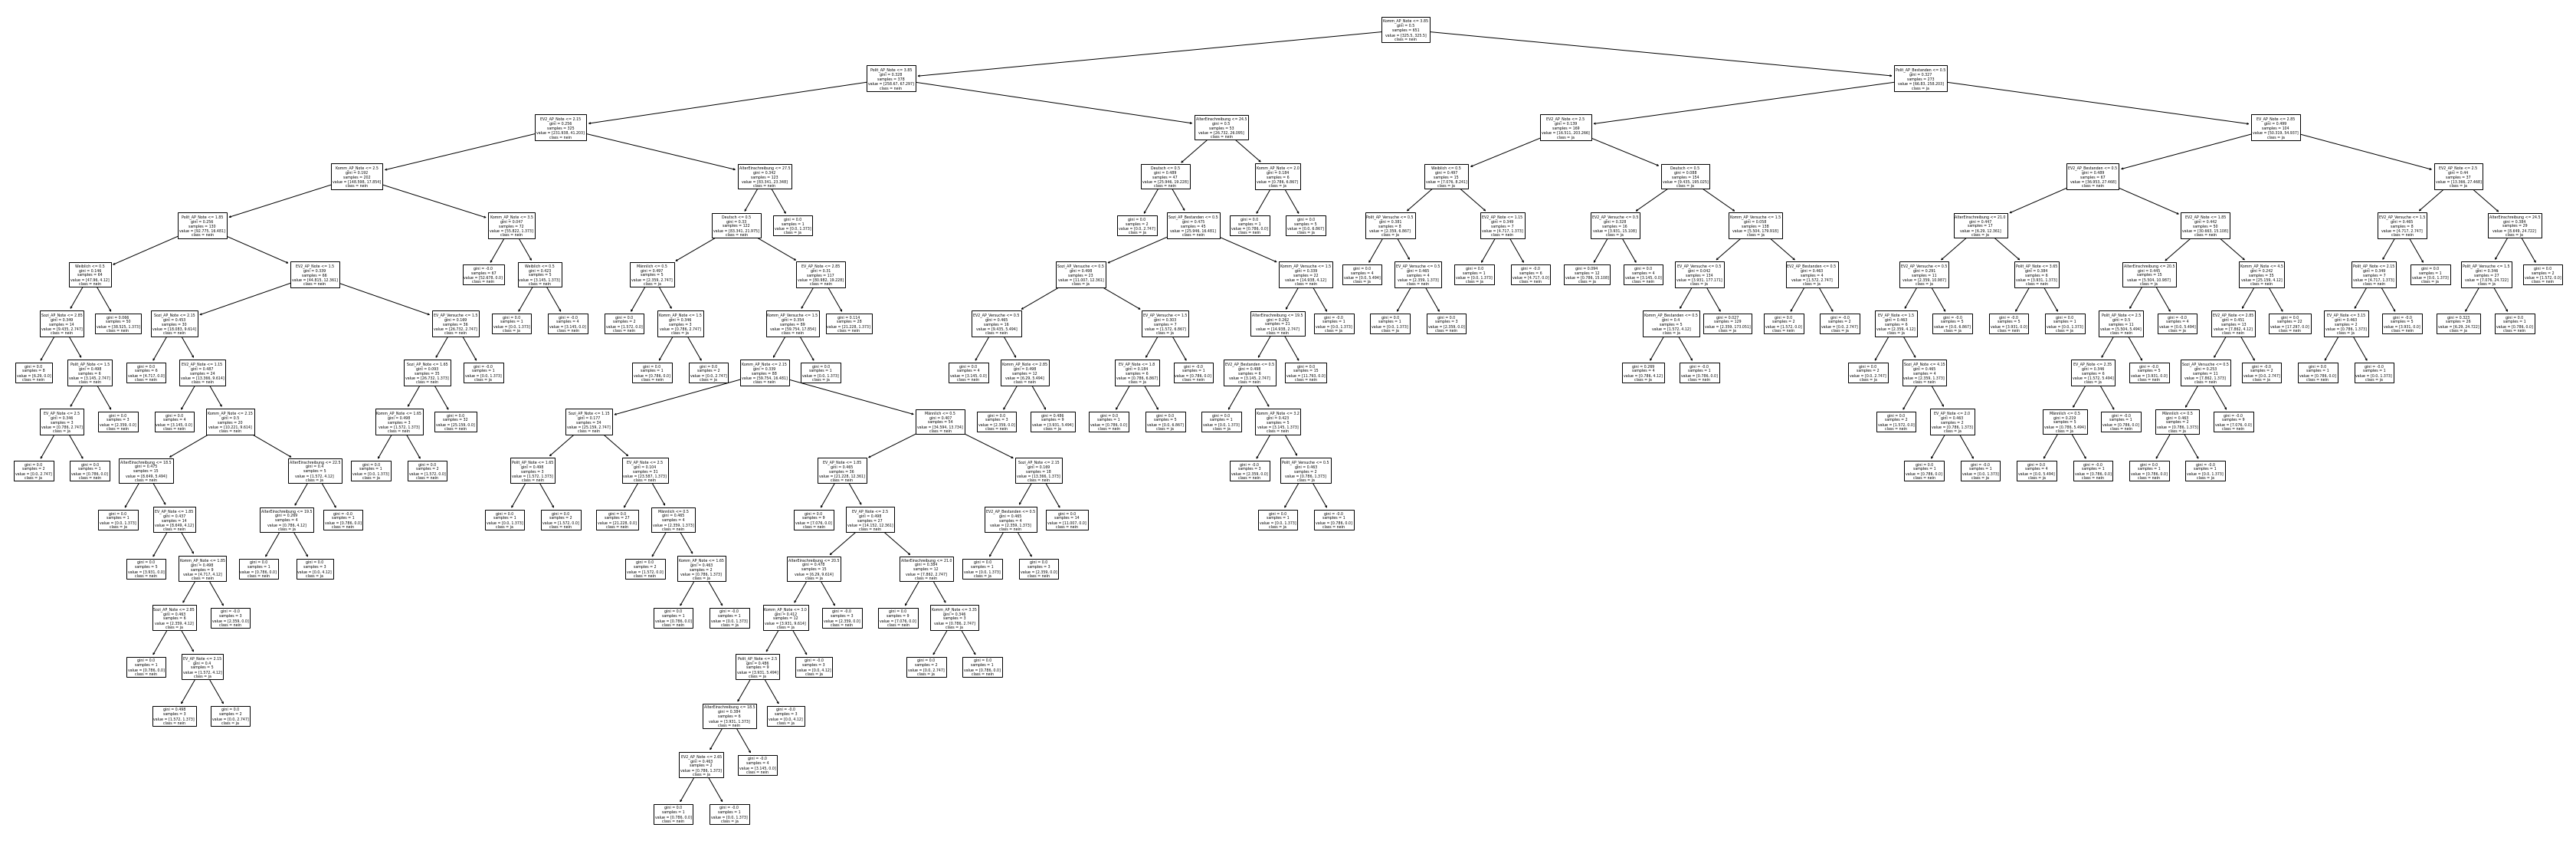

In [12]:
plot_tree(clf, feature_names = feature_names, class_names=["nein", "ja"])
plt.show()

### Post pruning

In [13]:
path = clf.cost_complexity_pruning_path(X_train, y_train)
path

{'ccp_alphas': array([0.        , 0.00117802, 0.0013189 , 0.00132908, 0.00133333,
        0.00146843, 0.00149704, 0.0015361 , 0.0015361 , 0.0015361 ,
        0.00156765, 0.00159086, 0.00164952, 0.00173188, 0.00174825,
        0.00177878, 0.00181047, 0.00181345, 0.00187793, 0.00187793,
        0.00187793, 0.00187793, 0.00190156, 0.00191312, 0.00195922,
        0.00196541, 0.00200661, 0.0020207 , 0.00205586, 0.00205905,
        0.00206536, 0.00210459, 0.00216732, 0.00229561, 0.00247419,
        0.00262361, 0.00263216, 0.00266667, 0.00269366, 0.00272708,
        0.00279355, 0.00312695, 0.00313634, 0.00315108, 0.0036425 ,
        0.00371418, 0.00375474, 0.0044722 , 0.00447283, 0.00603821,
        0.00757003, 0.016011  , 0.03549976, 0.1728341 ]),
 'impurities': array([0.04420688, 0.04656292, 0.04920072, 0.05318796, 0.05585463,
        0.05879148, 0.06028853, 0.06182463, 0.06336072, 0.06489682,
        0.06646447, 0.06805533, 0.07135436, 0.07308623, 0.07658274,
        0.08369787, 0.08731881

Text(0, 0.5, 'Balanced Accuracy scores')

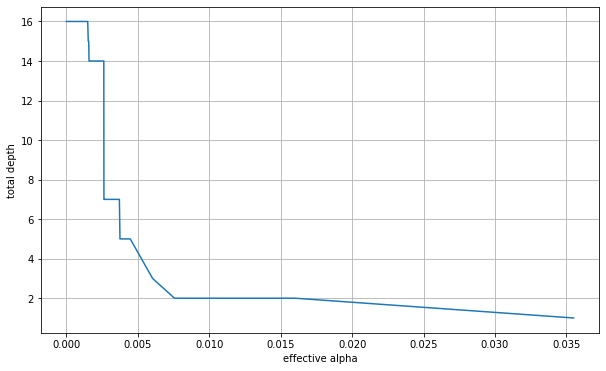

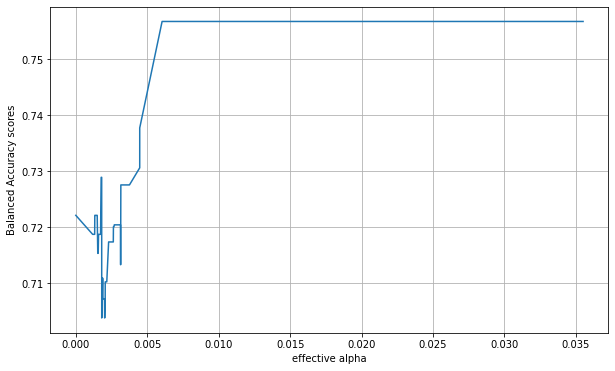

In [14]:
ccp_alphas, impurities = path.ccp_alphas, path.impurities

clfs = []

for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha,
                                 class_weight="balanced", min_impurity_decrease=0.001)
    clf.fit(X_train, y_train)
    clfs.append(clf)

tree_depths = [clf.tree_.max_depth for clf in clfs]
plt.figure(figsize=(10,  6))
plt.grid()
plt.plot(ccp_alphas[:-1], tree_depths[:-1])
plt.xlabel("effective alpha")
plt.ylabel("total depth")


acc_scores = [balanced_accuracy_score(y_test, clf.predict(X_test)) for clf in clfs]

plt.figure(figsize=(10,  6))
plt.grid()
plt.plot(ccp_alphas[:-1], acc_scores[:-1])
plt.xlabel("effective alpha")
plt.ylabel("Balanced Accuracy scores")

# Trainset
Balanced accuracy: 0.7939674677429218
Area under curve: 0.7939674677429218
Confusion Matrix (tn, fp, fn, tp):
[[329  85]
 [ 49 188]]
# Testset
Balanced accuracy: 0.7568027210884354
Area under curve: 0.7568027210884353
Confusion Matrix (tn, fp, fn, tp):
[[128  19]
 [ 25  45]]


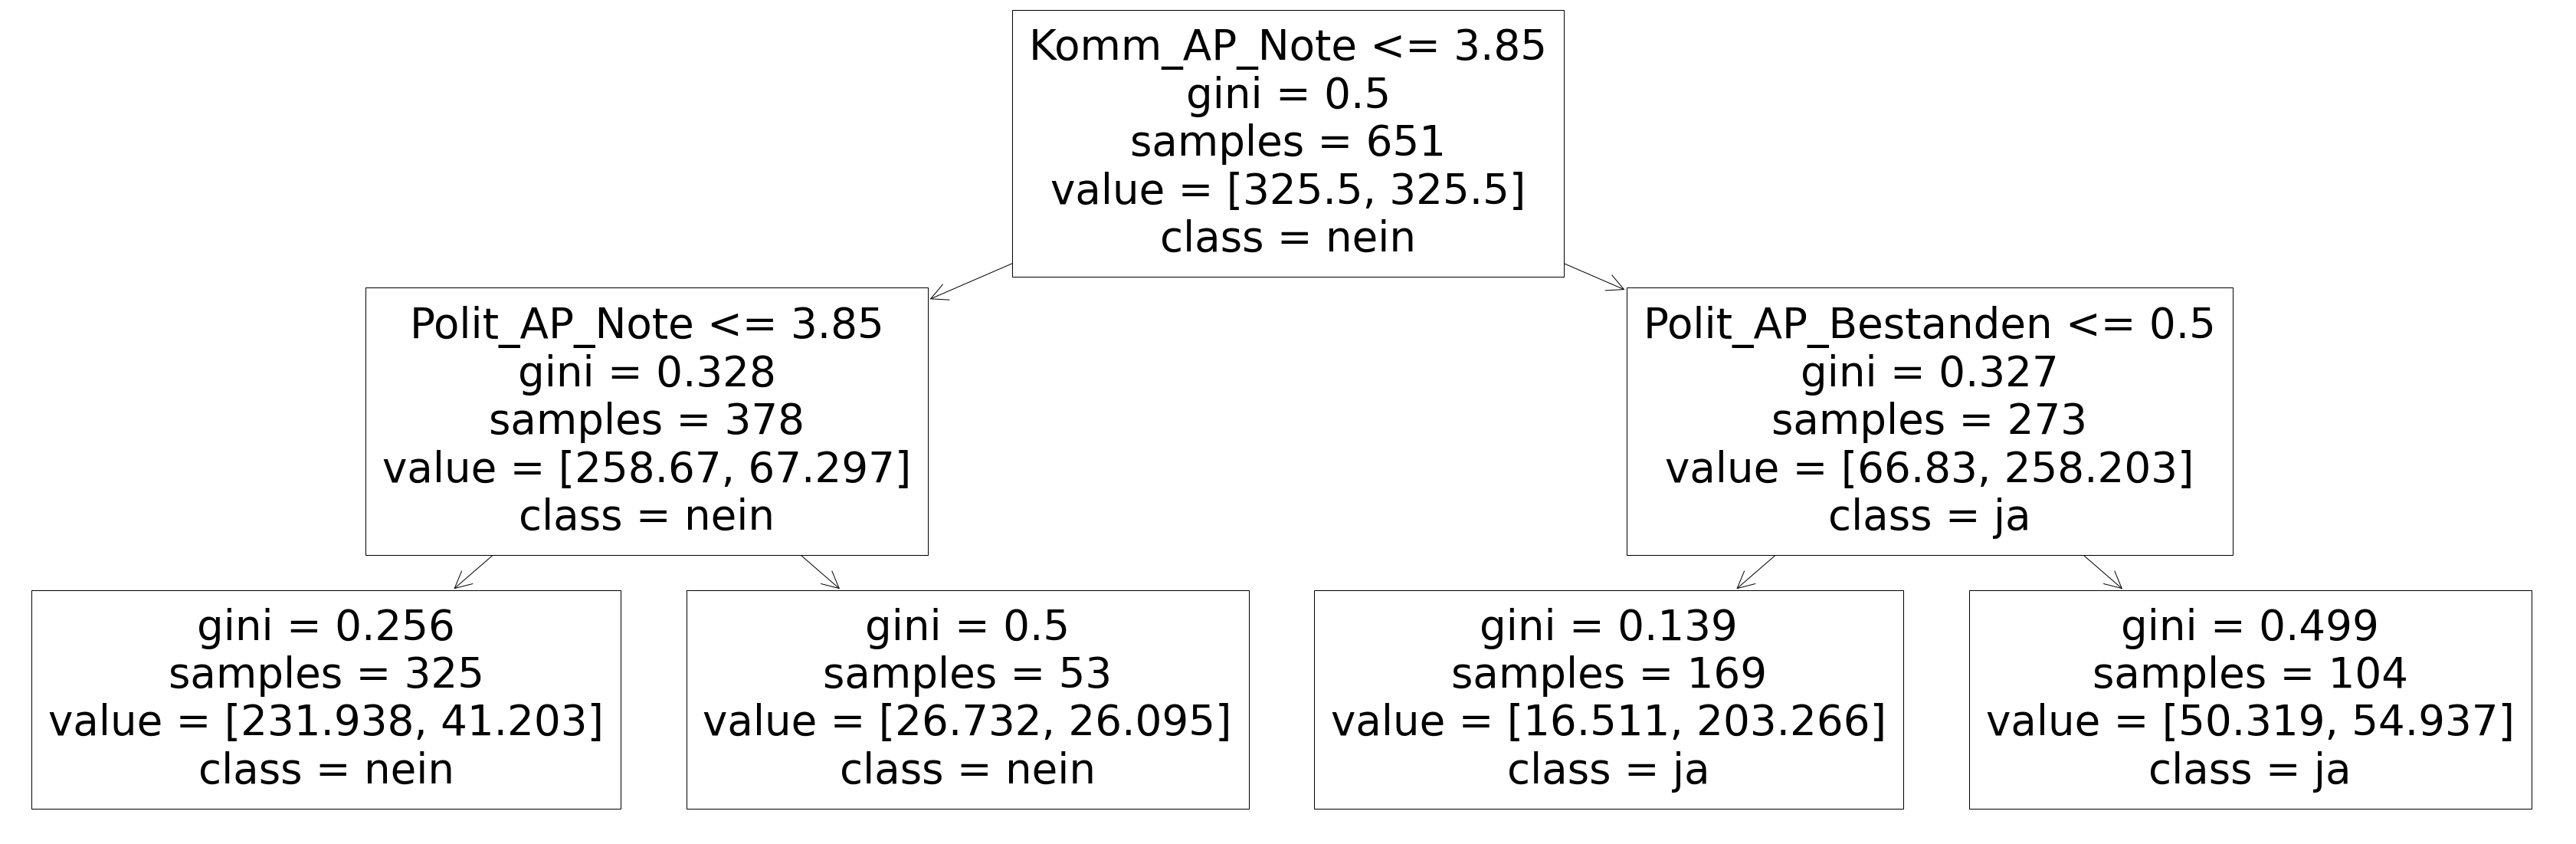

In [15]:
selected_ccp = 0.0125


clf = DecisionTreeClassifier(random_state=0, class_weight="balanced", min_impurity_decrease=0.001,
                             ccp_alpha=selected_ccp)
clf.fit(X_train, y_train)

eval_model(clf)
plot_tree(clf, feature_names = feature_names, class_names=["nein", "ja"])
plt.show()

# Trainset
Balanced accuracy: 0.7939674677429218
Area under curve: 0.7939674677429218
Confusion Matrix (tn, fp, fn, tp):
[[329  85]
 [ 49 188]]
# Testset
Balanced accuracy: 0.7568027210884354
Area under curve: 0.7568027210884353
Confusion Matrix (tn, fp, fn, tp):
[[128  19]
 [ 25  45]]


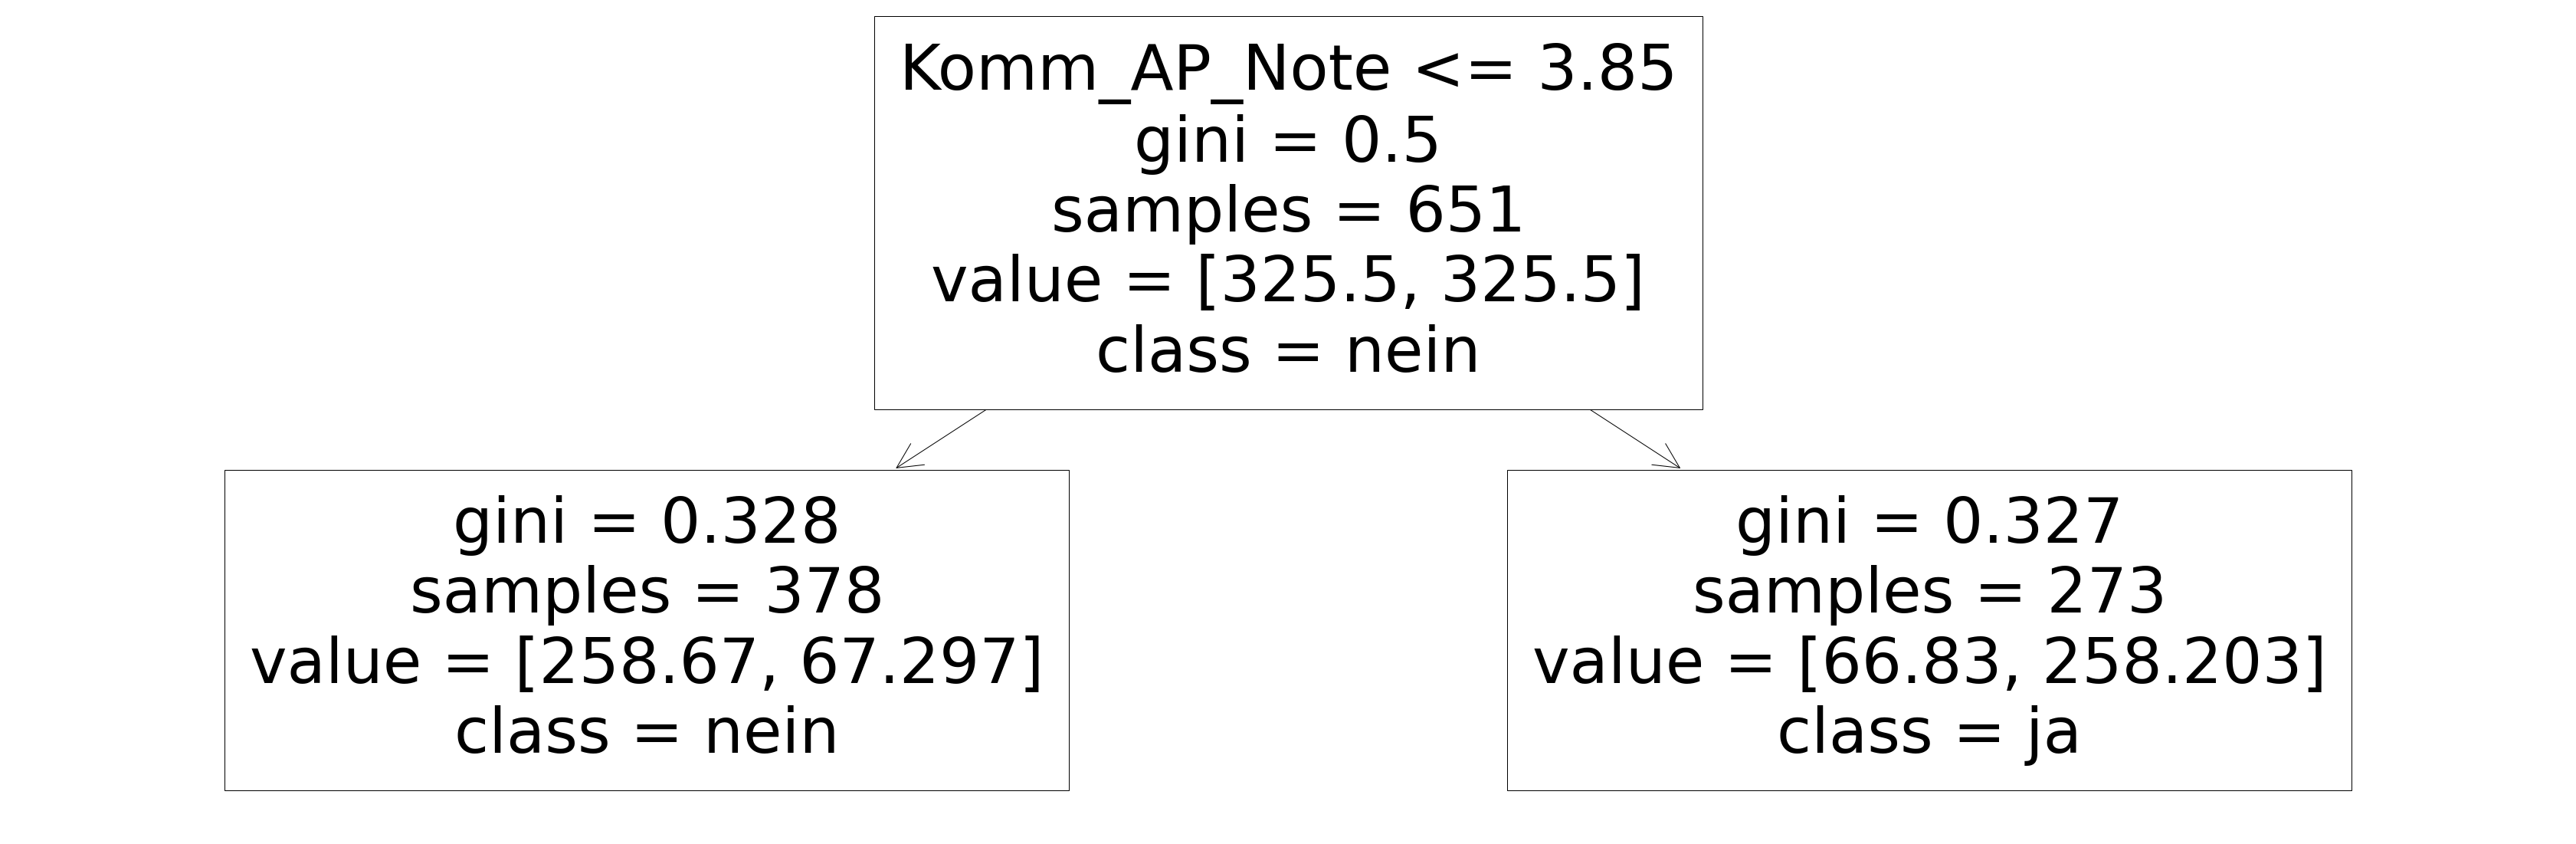

In [16]:
selected_ccp = 0.04


clf = DecisionTreeClassifier(random_state=0, class_weight="balanced", min_impurity_decrease=0.001,
                             ccp_alpha=selected_ccp)
clf.fit(X_train, y_train)

eval_model(clf)
plot_tree(clf, feature_names = feature_names, class_names=["nein", "ja"])
plt.show()
